# Rotation Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchnet as tnt
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

use:  cuda


In [3]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# Custom Pokemon dataset
<br>

## We will use this dataset for testing.

In [4]:
pokemon = np.load('/home/devcat/data/pokemon/rotate/pokemon.npy')

In [5]:
pokemonset = []
def rotate(image,rot):
    if rot == 0: return np.transpose(image,(2,0,1))
    elif rot == 90: return np.transpose(np.rot90(image),(2,0,1))
    elif rot == 180: return np.transpose(np.rot90(image, 2),(2,0,1))
    elif rot == 270: return np.transpose(np.rot90(image, 3),(2,0,1))
    else: raise ValueError('rotation should be 0, 90, 180, or 270 degrees')
        
for image in pokemon:
    pokemonset.append(torch.from_numpy(rotate(image,0).copy()))
    pokemonset.append(torch.from_numpy(rotate(image,90).copy()))
    pokemonset.append(torch.from_numpy(rotate(image,180).copy()))
    pokemonset.append(torch.from_numpy(rotate(image,270).copy()))

In [6]:
pokemonset[0].size()

torch.Size([3, 120, 120])

In [7]:
pokemon_label = [0,1,2,3]*int(len(pokemonset)/4)

In [8]:
class CustomDataset(Dataset):
    def __init__(self,image,label):
        self.x = image
        self.y = label
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [9]:
pokemon_set = CustomDataset(pokemonset, pokemon_label)

In [10]:
pokemon_loader = torch.utils.data.DataLoader(pokemon_set,batch_size=128, shuffle=False, drop_last=True)

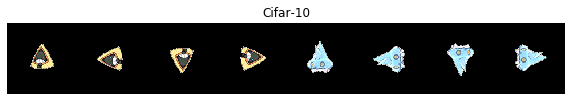

In [11]:
def imshow(img):
    npimg = img.numpy()
    timg=np.transpose(npimg ,(1,2,0))
    plt.figure(figsize=(10,10))
    plt.title('Cifar-10')
    plt.axis('off') 
    plt.imshow(timg)
img, labels = next(iter(pokemon_loader))
imshow(torchvision.utils.make_grid(img[:8]))

# Load the cifar dataset

In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Implement rotation transformation

In [13]:
train_temp = []
test_temp = []

for image,_ in trainset:
    train_temp.append(image)

for image,_ in testset:
    test_temp.append(image)

In [14]:
rot_trainset =[]
rot_testset = []

def rotate(image,rot):
    if rot == 0: return np.transpose(image,(2,0,1))
    elif rot == 90: return np.transpose(np.rot90(image),(2,0,1))
    elif rot == 180: return np.transpose(np.rot90(image, 2),(2,0,1))
    elif rot == 270: return np.transpose(np.rot90(image, 3),(2,0,1))
    else: raise ValueError('rotation should be 0, 90, 180, or 270 degrees')
        
for image in train_temp:
    npimage = image.numpy()
    timage = np.transpose(npimage,(1,2,0))
    rot_trainset.append(torch.from_numpy(rotate(timage,0).copy()))
    rot_trainset.append(torch.from_numpy(rotate(timage,90).copy()))
    rot_trainset.append(torch.from_numpy(rotate(timage,180).copy()))
    rot_trainset.append(torch.from_numpy(rotate(timage,270).copy()))

In [15]:
for image in test_temp:
    npimage = image.numpy()
    timage = np.transpose(npimage,(1,2,0))
    rot_testset.append(torch.from_numpy(rotate(timage,0).copy()))
    rot_testset.append(torch.from_numpy(rotate(timage,90).copy()))
    rot_testset.append(torch.from_numpy(rotate(timage,180).copy()))
    rot_testset.append(torch.from_numpy(rotate(timage,270).copy()))

In [16]:
train_label = [0,1,2,3]*int(len(rot_trainset)/4)
test_label = [0,1,2,3]*int(len(rot_testset)/4)

In [17]:
custom_trainset = CustomDataset(rot_trainset, train_label)
custom_testset = CustomDataset(rot_testset, test_label)

In [18]:
trainloader = torch.utils.data.DataLoader(custom_trainset,batch_size=128, shuffle=False, drop_last=True)
testloader = torch.utils.data.DataLoader(custom_testset,batch_size=128, shuffle=False, drop_last=True)

# Check image

In [19]:
image,label = next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


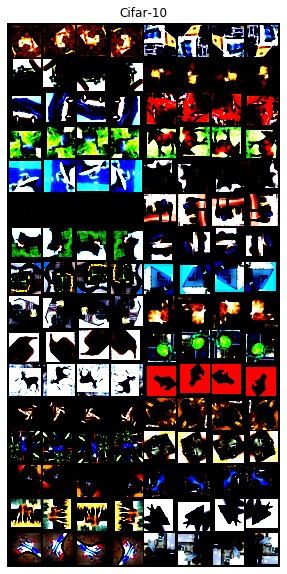

In [20]:
imshow(torchvision.utils.make_grid(image[:128]))

In [21]:
index = torch.randperm(image.size()[0])
image = image.view(image.size()[-4],image.size()[-3],image.size()[-2],image.size()[-1])[index]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


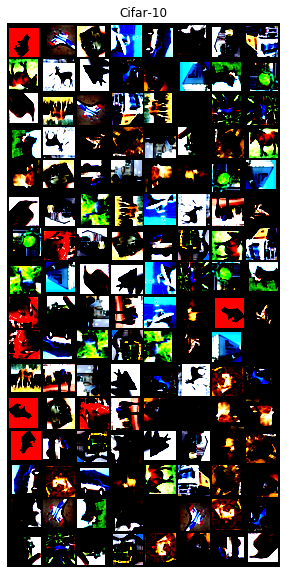

In [22]:
imshow(torchvision.utils.make_grid(image[:128]))

# Model

In [23]:
class NIN(nn.Module):
    def __init__(self):
        super(NIN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 192, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, 1, stride=1, bias=False),
            nn.BatchNorm2d(160),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, 1, stride=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1, dilation=1, ceil_mode=False),

            nn.Conv2d(96, 192, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 1, stride=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 1, stride=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2, padding=1),

            nn.Conv2d(192, 192, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 1, stride=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 1, stride=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2, padding=1),
            
            nn.Conv2d(192, 192, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 1, stride=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 1, stride=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(4, stride=1)

        )
        self._initialize_weights()
        self.linear = nn.Linear(192, 4, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.weight.requires_grad:
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                if m.weight.requires_grad:
                    m.weight.data.fill_(1)
                if m.bias.requires_grad:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                if m.bias.requires_grad:
                    m.bias.data.zero_()

In [24]:
model = NIN().to(device)

In [25]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [26]:
total_batch = len(trainloader)
print(f'total_batch : {total_batch}')

total_batch : 1562


In [27]:
from tqdm import tqdm

training_epoch = 100
train_accuracy_list = []
test_accuracy_list = []
for epoch in tqdm(range(training_epoch), disable=False, mininterval=0.01):
    train_accuracy = 0
    test_accuracy = 0
    model.train()
    for x,y in trainloader:
        idx = torch.randperm(x.size()[0])
        x = x.view(x.size()[-4],x.size()[-3],x.size()[-2],x.size()[-1])[idx]
        y = y[idx]
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_accuracy += (output.argmax(1)==y).float().mean()
    train_accuracy_list.append(train_accuracy/total_batch)
    scheduler.step(loss)
    model.eval()
    for x,y in testloader:
        with torch.no_grad():
            x = x.view(x.size()[-4],x.size()[-3],x.size()[-2],x.size()[-1])[idx]
            y = y[idx]
            x = x.to(device)
            y = y.to(device)
            result = model(x)
            test_accuracy += (result.argmax(1)==y).float().mean()
    test_accuracy_list.append(test_accuracy/len(testloader))

100%|██████████| 100/100 [2:18:56<00:00, 83.36s/it] 


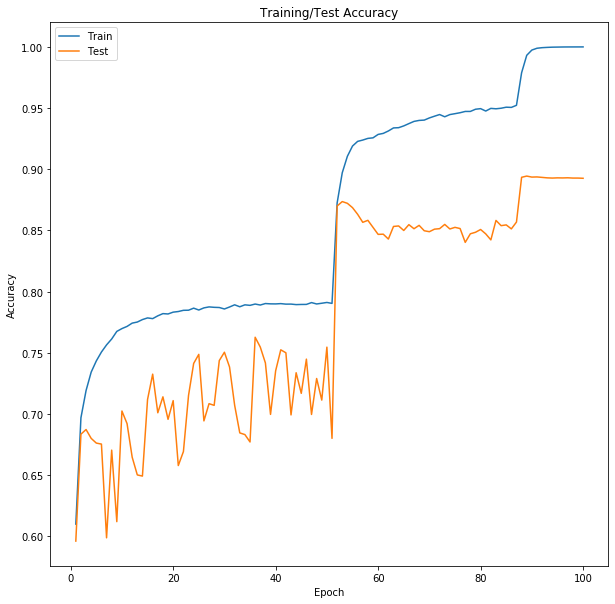

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_accuracy_list)+1), train_accuracy_list)
ax.plot(range(1, len(test_accuracy_list)+1), test_accuracy_list)
ax.legend(['Train', 'Test'])
plt.show()

In [29]:
torch.save({
            'epoch': training_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'train_accuracy': train_accuracy_list,
            'test_accuracy' : test_accuracy_list
            }, './save/RotNet_checkpoint.pt')

In [30]:
ck = torch.load('./save/RotNet_checkpoint.pt')

In [31]:
ck['test_accuracy'][99]

tensor(0.8926, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


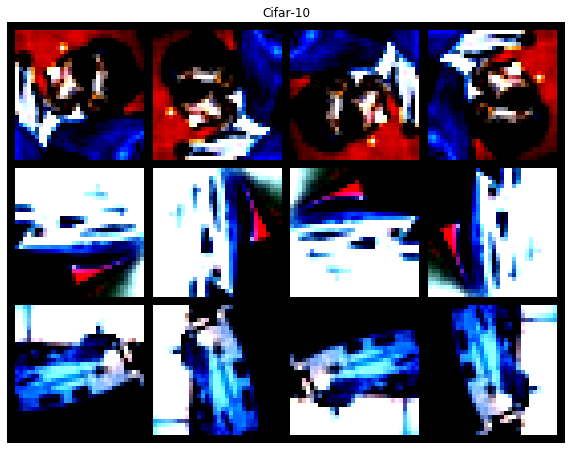

In [32]:
a,b=next(iter(testloader))
imshow(torchvision.utils.make_grid(a[:12],nrow=4))

In [33]:
b[:12]

tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

In [36]:
class_names = [0,1,2,3]

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

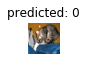

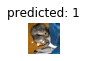

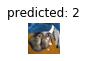

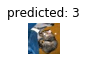

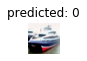

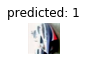

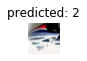

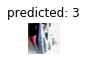

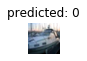

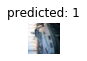

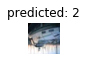

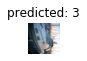

In [37]:
visualize_model(model)